# 决策树与随机森林

## Decision Trees

In [1]:
from warnings import filterwarnings
filterwarnings('ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

### 决策树可视化 

In [2]:
# 导入iris数据
iris = load_iris()

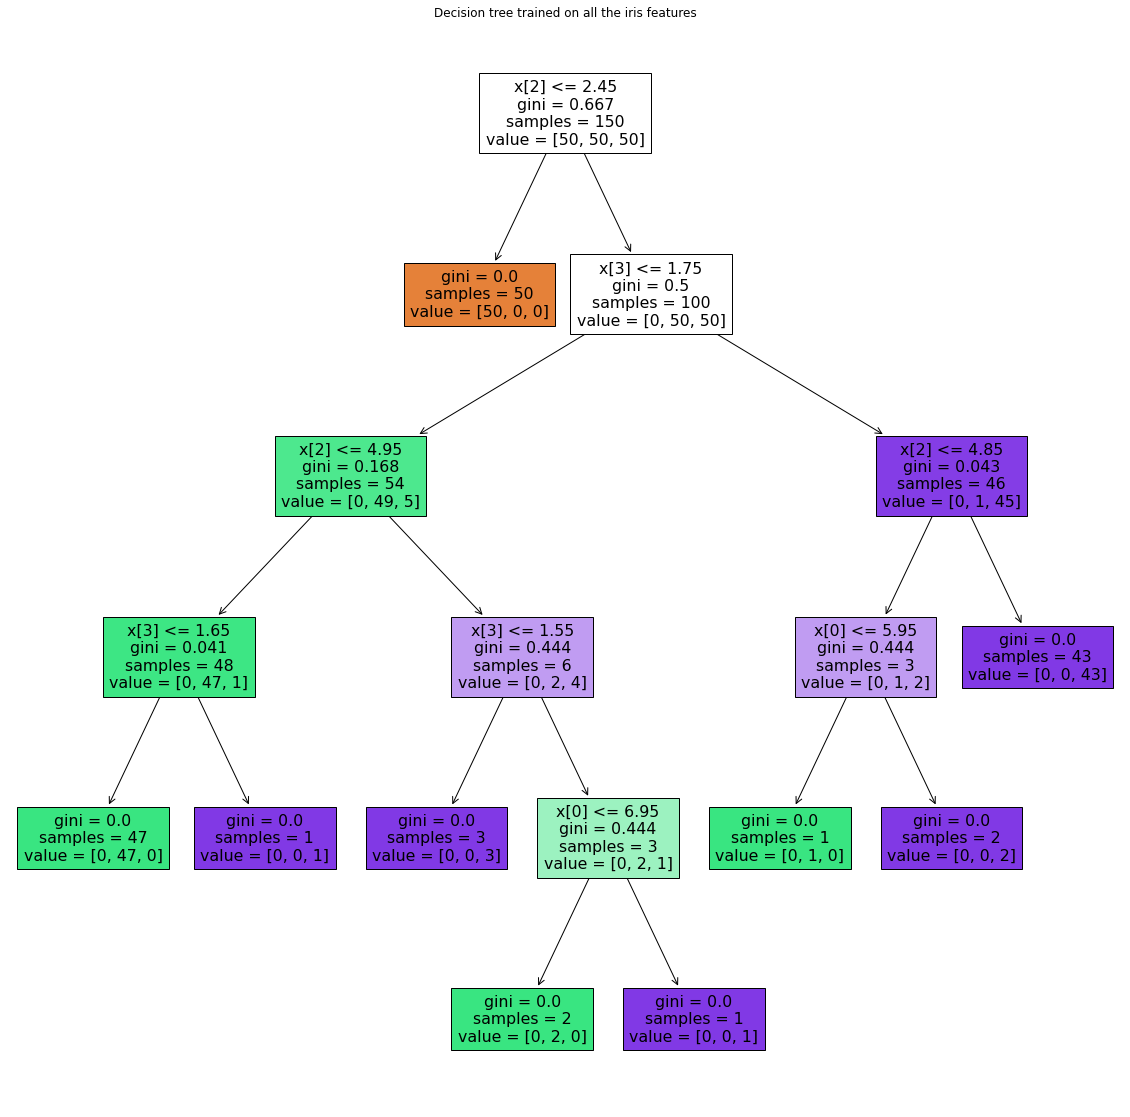

In [3]:
plt.figure(figsize=(20, 20))
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

### 决策树决策边界

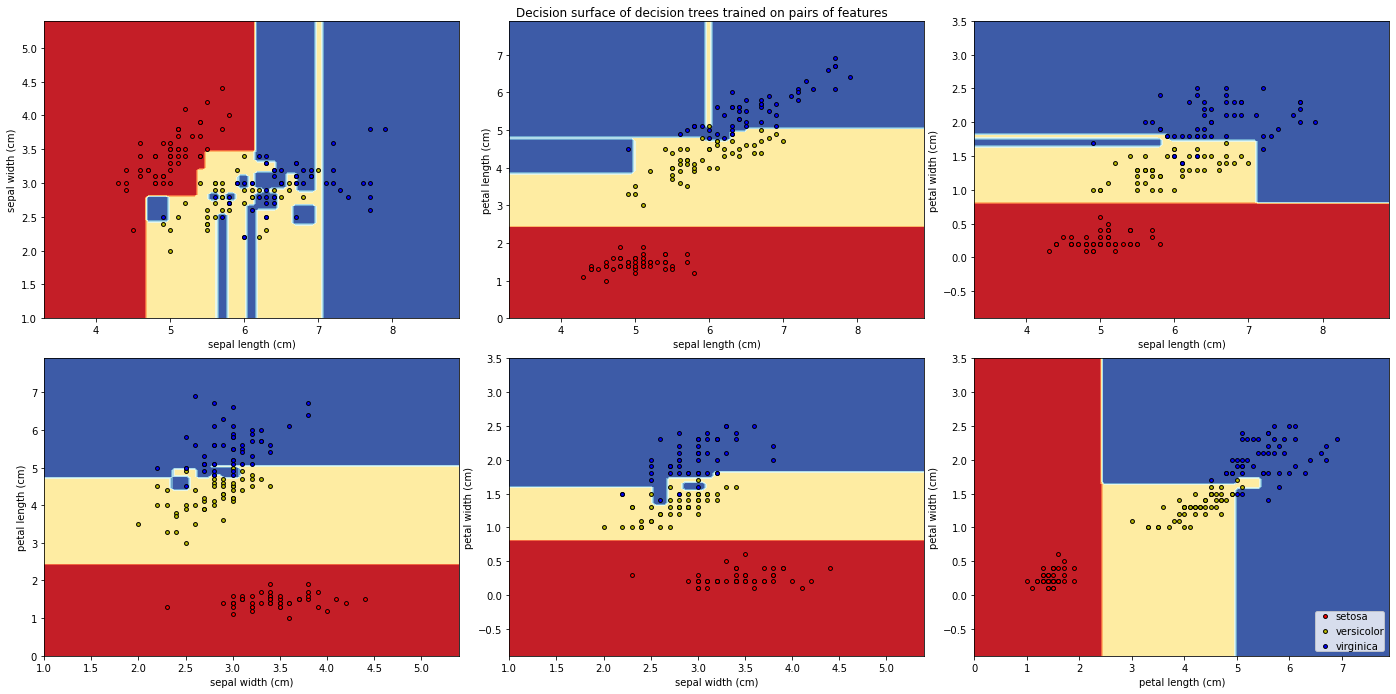

In [4]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02
plt.figure(figsize=(20, 10))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=iris.feature_names[pair[0]],
        ylabel=iris.feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

### 决策树处理回归问题

In [5]:
# Import the necessary modules and libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

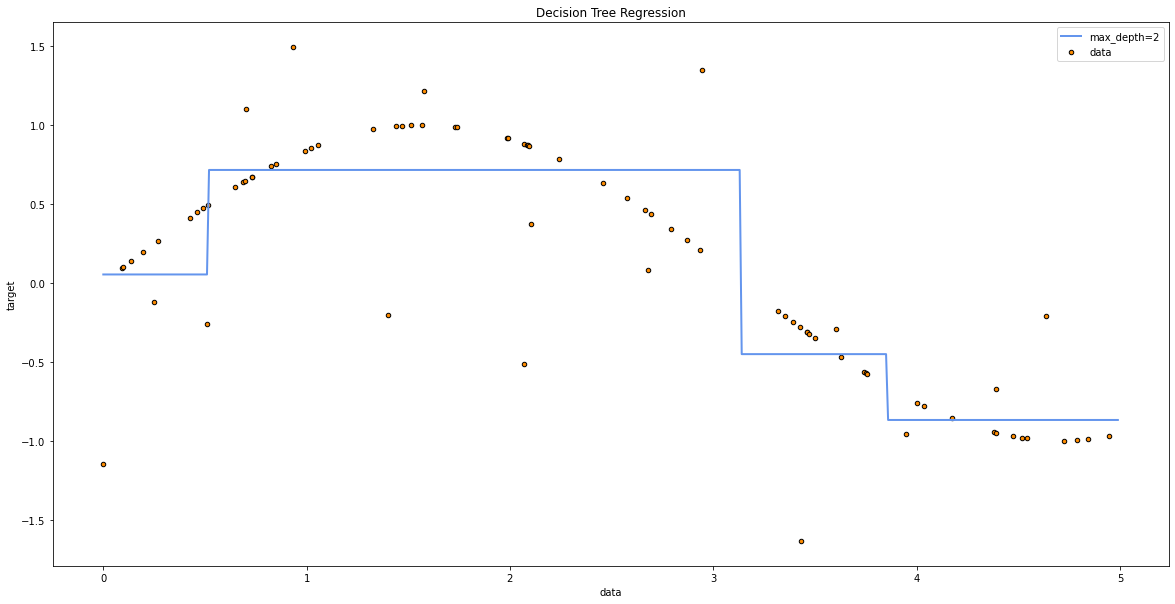

In [6]:
# Plot the results
plt.figure(figsize=(20, 10))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

The decision trees is used to fit a sine curve with addition noisy observation. As a result, it learns local linear regressions approximating the sine curve.

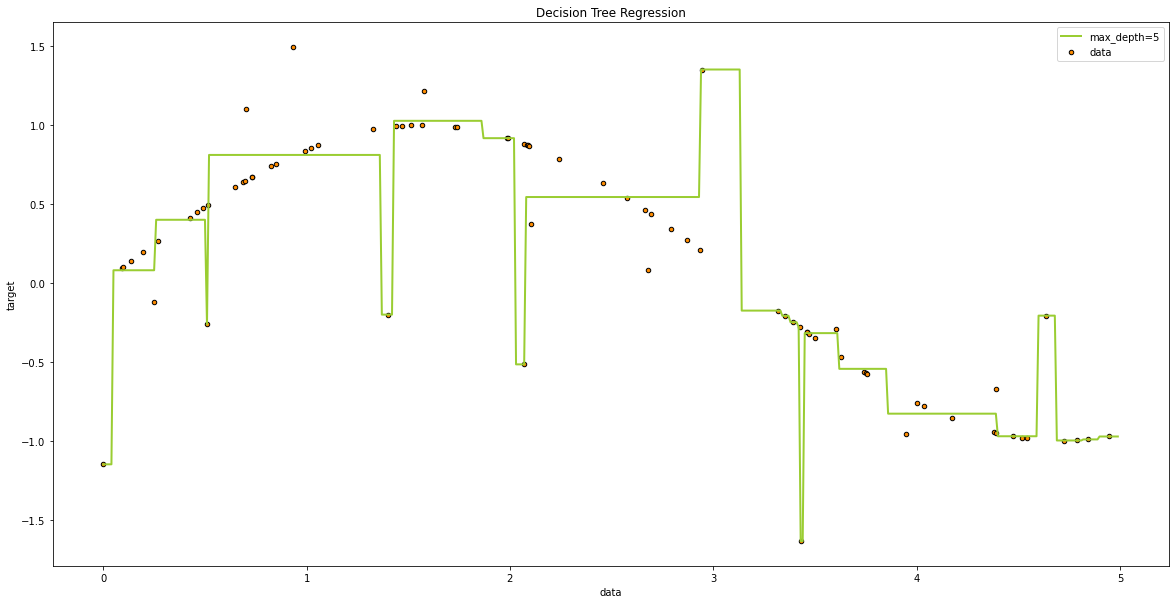

In [7]:
# Plot the results
plt.figure(figsize=(20, 10))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

if the maximum depth of the tree (controlled by the max_depth parameter) is set too high, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit.

## Random Forest
### 自助法（Bootstraping）
定义

- 有放回的采样或重复采样。在含有 m 个样本的数据集中，每次随机挑选一个样本， 将其作为训练样本，再将此样本放回到数据集中，这样有放回地抽样 m 次，生成一个与原数据集大小相同的数据集，这个新数据集就是训练集。这样有些样本可能在训练集中出现多次，有些则可能从未出现。原数据集中大概有 36.8% 的样本不会出现在新数据集中。因此，我们把这些未出现在新数据集中的样本作为验证集。把前面的步骤重复进行多次，这样就可以训练出多个模型并得到它们的验证误差，然后取平均值，作为该模型的验证误差。

特点

- 自助法在数据集较小，难以有效划分训练集/验证集时很有用；此外，自助法能从初始数据集中产生多个不同的训练集，这对集成学习等方法有很大的好处。

In [8]:
import numpy as np

sample_size = 100000
original_data = np.arange(sample_size) 
bootstrap_samples = [np.random.choice(original_data) for _ in range(sample_size)]
1 - len(set(bootstrap_samples)) / sample_size

0.36676

In [9]:
bootstrap_samples = np.random.choice(original_data, size=sample_size, replace=True)
print(1 - len(set(bootstrap_samples)) / sample_size)

0.36705


### OOB
The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations. The out-of-bag (OOB) error is the average error for each calculated using predictions from the trees that do not contain in their respective bootstrap sample. This allows the RandomForestClassifier to be fit and validated whilst being trained.

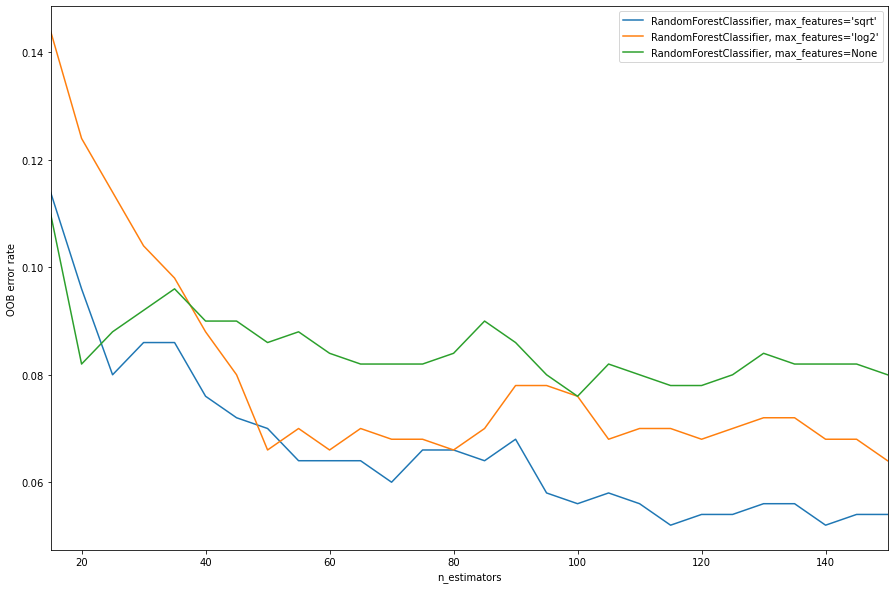

In [10]:
from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(
    n_samples=500,
    n_features=25,
    n_clusters_per_class=1,
    n_informative=15,
    random_state=RANDOM_STATE,
)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(15, 10))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

### Feature importance evaluation
- The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

- By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. 

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Feature importance based on mean decrease in impurity
- Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [13]:
import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


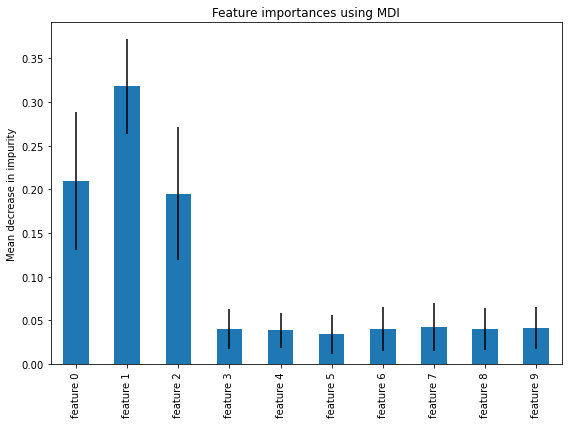

In [14]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)


fig, ax = plt.subplots(figsize=(8, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Feature importance based on feature permutation
- Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [15]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 2.878 seconds


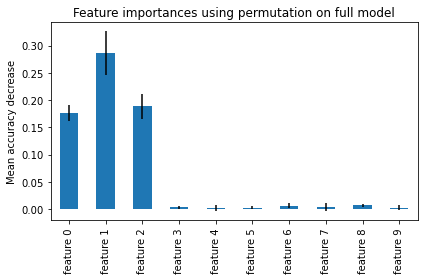

In [16]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

#### Permutation Importance vs Random Forest Feature Importance(MDI)
- the impurity-based feature importance can inflate the importance of numerical features.

- the impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

Data Loading and Feature Engineering
- random_num is a high cardinality numerical variable (as many unique values as records).
- random_cat is a low cardinality categorical variable (3 possible values).

高基数数据（High Cardinality Data）是指在一个数据集中某一列或属性具有极高数量的不同唯一值的情形。如果一个列中的值几乎互不相同或者重复率极低，那么我们就称这个列为高基数列。电子邮件地址、用户名、产品唯一码等也是典型的高基数数据。

In [17]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

preprocessing steps(可以跳过)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

#### Tree’s Feature Importance from Mean Decrease in Impurity (MDI)

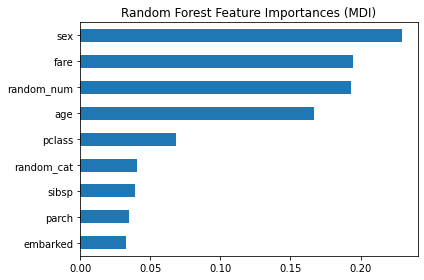

In [19]:
import pandas as pd

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

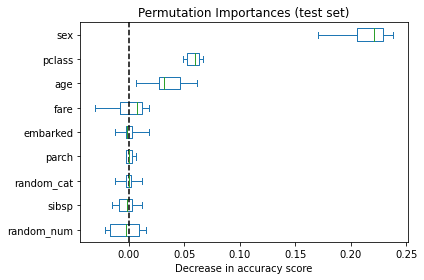

In [20]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# More Reading Materials
- https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance